In [16]:
import pickle
import os
import sys
import pandas as pd
import yfinance as yf
import numpy as np
sys.path.append(os.path.join('ML_additoinal_files'))

from config import *
from helper import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from time import time
import xgboost as xgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None 

In [3]:
price_data_df = collecting_data(START_DATE, END_DATE, DATA_OPEN_LOC, DATA_CLOSE_LOC, DATA_HIGH_LOC, DATA_LOW_LOC, DATA_VOL_LOC, DATA_DIV_LOC)
relative_df = get_relative(price_data_df)
risk_free_rate_list = get_risk_free_rate(START_DATE, END_DATE)
risk_free_rate = float(risk_free_rate_list.mean())
open_positions = momentum_strategy_stat(price_data_df, relative_df)

/home/or/dev/momentum_strategy/ML_additoinal_files/helper.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  relative_df = pd.concat([relative_df, row_df])
[*********************100%***********************]  1 of 1 completed
/home/or/dev/momentum_strategy/ML_additoinal_files/helper.py:258: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_risk_free_rate = treasury_bond_yield[STOCK_TIME].resample('Y').mean()


In [7]:
features_dict = calc_variability_per_stocks(price_data_df, open_positions, risk_free_rate, GROUP_LABELS)

/tmp/ipykernel_22333/3184753342.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  prices_flunc_p = float(np.std(block['Close'][stock] - block['Open'][stock]) / np.mean(block['Close'][stock] - block['Open'][stock]))


In [68]:
df = pd.DataFrame(features_dict).T
df = df[~df.isin([float('inf'), float('-inf')]).any(axis=1)]
train_range = int(len(features_dict) * TRAIN_SPLIT)

train_df = df.iloc[:train_range]
test_df = df.iloc[train_range:]
print(f'Train length: {train_df.shape}, Test length: {test_df.shape}')

Train length: (12776, 23), Test length: (5462, 23)


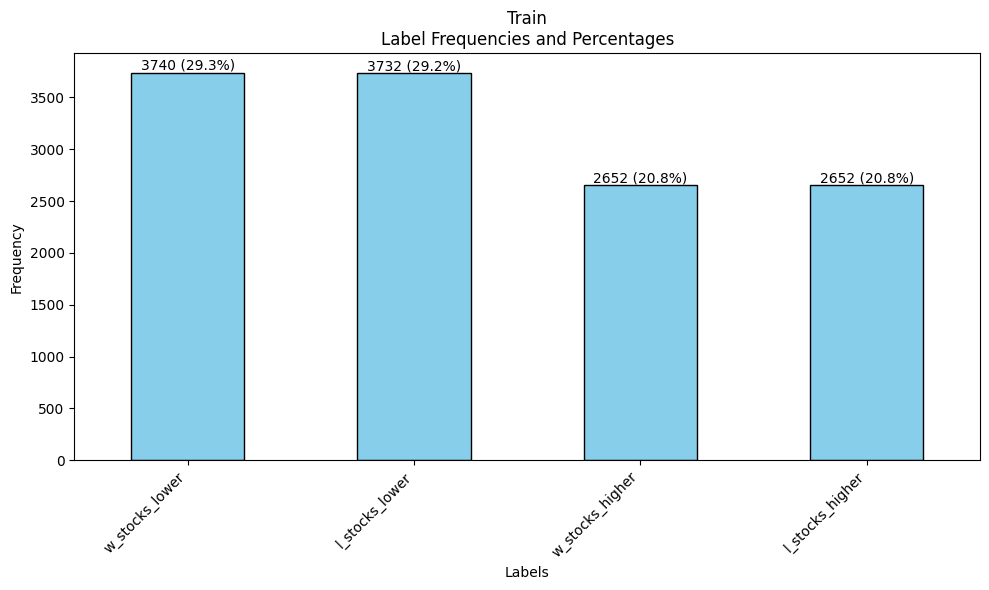

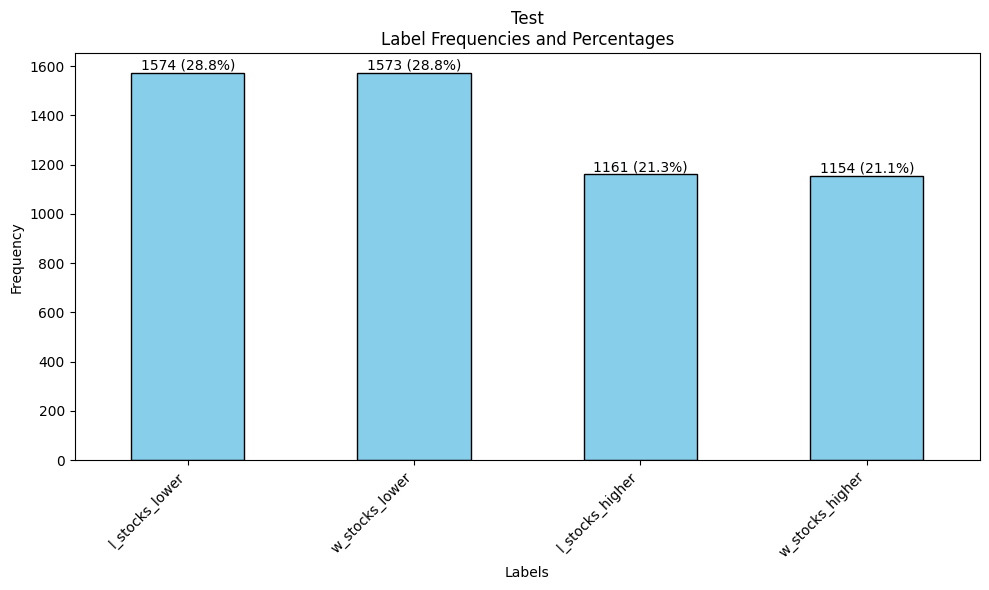

In [69]:
group_labels_to_str = {v: k for k, v in GROUP_LABELS.items()}

plot_label_frequency(train_df, group_labels_to_str, 'Train')
plot_label_frequency(test_df, group_labels_to_str, 'Test')

In [78]:

pipeline = Pipeline(steps=[('classifier', AdaBoostClassifier())])

# Bootstrap aggregating
RandomForestClassifier_param = {'classifier': [RandomForestClassifier()],
                                'classifier__n_estimators': [100],
                                'classifier__max_depth': [10],
                                'classifier__class_weight': ['balanced'],
                                'classifier__min_samples_split': [2],
                                'classifier__random_state': [RANDOM_STATE]}
# Boosting
AdaBoost_param = {'classifier': [AdaBoostClassifier()],
                  'classifier__n_estimators': [100, 200],
                  'classifier__learning_rate': [0.1, 1],
                  'classifier__random_state': [RANDOM_STATE]}

GBClassifier_param = {'classifier': [GradientBoostingClassifier()],
                      'classifier__n_estimators': [100, 200],    
                      'classifier__max_depth': [3],
                      'classifier__subsample': [0.1, 1.0],
                      'classifier__learning_rate': [1],
                      'classifier__random_state': [RANDOM_STATE]}

# XGBClassifier_param = {'classifier': [xgb.XGBClassifier(use_label_encoder=False)],
#                        'classifier__eta': [0.1],
#                        'classifier__gamma': [1.5],
#                        'classifier__max_depth': [6],
#                        'classifier__subsample': [1.0],
#                        'classifier__min_child_weight': [1.0],
#                        'classifier__eval_metric': ['mlogloss'],
#                        'classifier__seed': [RANDOM_STATE]}


params = [AdaBoost_param, RandomForestClassifier_param, GBClassifier_param]#, XGBClassifier_param]

gs = GridSearchCV(pipeline, param_grid=params, refit='f1_weighted', return_train_score=True, cv=10, n_jobs=-1, scoring='f1_weighted')

tic = time()
exclude_columns = ['date', 'label_name','stock']
clean_train_df = train_df.loc[:, ~train_df.columns.isin(exclude_columns)]

X = clean_train_df.drop(columns=['label'])
y =  pd.to_numeric(clean_train_df['label'])

print('train_df:',X.shape)
gs.fit(X, y)
toc = time()
print(f'GridSearchCV time(mintues): {round((toc-tic)/60,2)}')

pd.DataFrame(gs.cv_results_)

train_df: (12776, 20)
GridSearchCV time(mintues): 30.95


{'mean_fit_time': array([ 6.44842803, 12.09785984,  5.7113795 , 11.37675197,  4.23421874,
         4.40685294, 41.64023199,  8.57221637, 83.71360459]),
 'std_fit_time': array([0.57605458, 1.81159225, 0.21225601, 0.3543798 , 0.25567626,
        0.26785202, 0.60938292, 0.29289224, 1.18227617]),
 'mean_score_time': array([0.12275257, 0.21120551, 0.09625704, 0.2070348 , 0.01825249,
        0.01080263, 0.00966883, 0.01670034, 0.01466453]),
 'std_score_time': array([0.03535518, 0.03570984, 0.00281546, 0.03239278, 0.00039705,
        0.00057255, 0.00033669, 0.00091126, 0.00039917]),
 'param_classifier': masked_array(data=[AdaBoostClassifier(), AdaBoostClassifier(),
                    AdaBoostClassifier(), AdaBoostClassifier(),
                    RandomForestClassifier(), GradientBoostingClassifier(),
                    GradientBoostingClassifier(),
                    GradientBoostingClassifier(),
                    GradientBoostingClassifier()],
              mask=[False, False, False, F

In [114]:
# test_df = test_df.drop(columns=['prediction'])

best_params = gs.best_params_
exclude_columns = ['date', 'label_name','stock', 'label']
clean_test_df = test_df.loc[:, ~test_df.columns.isin(exclude_columns)]

test_df['prediction'] = gs.predict(clean_test_df)


test_df['label'] = test_df['label'].astype(int)
test_df['prediction'] = test_df['prediction'].astype(int)  

r_score = recall_score(test_df['prediction'], test_df['label'] , average = 'weighted')
p_score = precision_score(test_df['prediction'], test_df['label'] , average = 'weighted')
f1_score = f1_score(test_df['prediction'].values, test_df['label'].values, average='weighted')


print(f'Precision: {p_score}\nRecall: {r_score}\nf1_score: {f1_score}\n')

Precision: 0.5330041586420843
Recall: 0.5217868912486269
f1_score: 0.5205256872131361

